# Varying non-specific binding rate

In [ ]:
%load_ext slurm_magic

In [ ]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=lamda
#SBATCH --output=simulations/lamda%a_%A.out
#SBATCH --gres=gpu:1   # Request 1 GPU
#SBATCH --array=0-4

lamdas=(0.01 0.05 0.15 0.5 1)

# Path to your executable
python ../examples/cosmos_simulations.py \
  --gain 7 --pi 0.15 --height 3000 --proximity 0.2 \
  -bs 4 --cuda --dtype double \
  --lamda ${lamdas[${SLURM_ARRAY_TASK_ID}]} \
  --path simulations/lamda${lamdas[${SLURM_ARRAY_TASK_ID}]}

In [ ]:
%squeue

In [1]:
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import torch
from matplotlib.patches import Circle
from matplotlib.ticker import FormatStrFormatter

from tapqir.models import Cosmos
from tapqir.utils.dataset import load

## Load results

In [2]:
# path to simulated data
SIMULATIONS_DIR = Path("simulations")

In [3]:
truth = {}
fit = {}
predictions = defaultdict(dict)

for data_path in SIMULATIONS_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("lamda"):
        # load results
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        
        model = Cosmos(verbose=False)
        model.load(data_path, data_only=False)
        
        fit[data_path.name] = model.statistics.drop("trained").astype(float)
        for p in ("gain", "proximity", "pi", "lamda", "SNR"):
            fit[data_path.name].loc[p, "True"] = truth[data_path.name][p]
        
        mask = torch.from_numpy(model.data.ontarget.labels["z"])
        samples = torch.masked_select(model.params["p(specific)"], mask)
        predictions[data_path.name]["z_masked"] = samples
        predictions[data_path.name]["z_all"] = model.params["p(specific)"].flatten()

In [4]:
truth_df = pd.concat(truth.values(), axis=1).T.sort_values(by="lamda").astype(float)
truth_df

,width,gain,pi,lamda,proximity,offset,height,background,SNR,N,F,Nc,Fc,P
lamda0.01,1.4,7.0,0.15,0.01,0.2,90.0,3000.0,150.0,3.758899,5.0,500.0,5.0,500.0,14.0
lamda0.05,1.4,7.0,0.15,0.05,0.2,90.0,3000.0,150.0,3.758899,5.0,500.0,5.0,500.0,14.0
lamda0.15,1.4,7.0,0.15,0.15,0.2,90.0,3000.0,150.0,3.758899,5.0,500.0,5.0,500.0,14.0
lamda0.5,1.4,7.0,0.15,0.50,0.2,90.0,3000.0,150.0,3.758899,5.0,500.0,5.0,500.0,14.0
lamda1,1.4,7.0,0.15,1.00,0.2,90.0,3000.0,150.0,3.758899,5.0,500.0,5.0,500.0,14.0


In [5]:
description = pd.Series(dtype=str, name="Description")
description["N"] = "Number of on-target AOIs"
description["F"] = "Number of frames for on-target AOIs"
description["Nc"] = "Number of control off-target AOIs"
description["Fc"] = "Number of frames for off-target AOIs"
description["P"] = "Number of pixels along x- and y-axes of an AOI"
description["height"] = "Spot intensity"
description["width"] = "Spot width"
description["snr"] = "Signal-to-noise ratio"
description["background"] = "Image background"
description["pi"] = "Average target-specific binding probability"
description["lamda"] = "Non-specific binding rate"
description["proximity"] = "Proximity parameter"
description["p(specific)"] = "Probability of there being any target-specific spot in an AOI image"
description["_ul"] = "95% CI upper-limit"
description["_ll"] = "95% CI lower-limit"
description["MCC"] = "Matthews correlation coefficient"
description["TP"] = "True positives"
description["FN"] = "False negatives"
description["TN"] = "True negatives"
description["FP"] = "False positives"

## Supplementary Data 1

In [ ]:
with pd.ExcelWriter("/home/ordabayev/repos/tapqir-overleaf/supplementary/data1/lamda.xlsx") as writer:
    truth_df.to_excel(writer, sheet_name="simulation")
    for key, value in fit.items():
        value.to_excel(writer, sheet_name=key)
    description.to_excel(writer, sheet_name="description")

## Figure 3

In [6]:
# load
path_data = SIMULATIONS_DIR / "lamda0.5"
model = Cosmos(verbose=False)
model.load(path_data, data_only=False)

n = 0
frames = [100, 103, 105, 108, 110, 113, 115, 118, 120]
f1, f2 = 100, 121
vmin, vmax = model.data.vmin, model.data.vmax

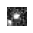

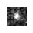

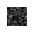

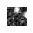

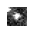

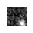

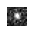

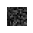

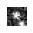

In [7]:
for f in frames:
    plt.figure(figsize=(0.35, 0.35))
    plt.axis("off")
    plt.imshow(model.data.ontarget.images[n, f].numpy(),
               vmin=vmin, vmax=vmax, cmap="gray")
    # plt.savefig(f"/home/ordabayev/repos/tapqir-overleaf/figures/figure3/lamda-aois-{f}.png", dpi=600)
    plt.show()

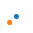

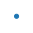

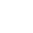

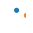

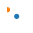

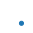

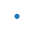

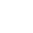

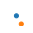

In [9]:
for f in frames:
    fig = plt.figure(figsize=(0.35, 0.35))

    plt.imshow(torch.ones((model.data.P, model.data.P)),
               vmin=0, vmax=1, cmap="gray")
    # add patch
    for k in range(2):
        if model.params["d/m_probs"][k, n, f].item() > 0.5:
            plt.gca().add_patch(
                Circle(
                    (model.data.ontarget.y[n, f] +
                     model.params["d/y"]["Mean"][k, n, f].item(),
                     model.data.ontarget.x[n, f] +
                     model.params["d/x"]["Mean"][k, n, f].item()),
                    1.5, color=f"C{k}"
                )
            )
    plt.axis("off")
    # plt.savefig(f"/home/ordabayev/repos/tapqir-overleaf/figures/figure3/lamda-{f}.png", dpi=600)
    plt.show()

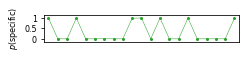

In [10]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    torch.arange(f1, f2),
    model.params["p(specific)"][n, f1:f2],
    "o-", ms=2, lw=0.5, color="C2", label="on-target"
)
plt.xticks([])
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p(\mathrm{specific})$", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/lamda-pspecific.svg")
plt.show()

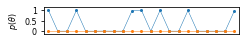

In [11]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    torch.arange(f1, f2),
    model.params["d/z_probs"][0, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C0", label=r"$\theta=1$"
)
plt.plot(
    torch.arange(f1, f2),
    model.params["d/z_probs"][1, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C1", label=r"$\theta=2$"
)
plt.xticks([])
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p(\theta)$", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/lamda-theta.svg")
plt.show()

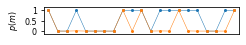

In [12]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    torch.arange(f1, f2),
    model.params["d/m_probs"][0, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C0", label=r"$m_{1}$"
)
plt.plot(
    torch.arange(f1, f2),
    model.params["d/m_probs"][1, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C1", label=r"$m_{2}$"
)
plt.xticks([])
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p(m)$", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/lamda-m.svg")
plt.show()

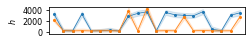

In [13]:
plt.figure(figsize=(3.5,0.5))

for k in range(2):
    plt.fill_between(
        torch.arange(f1, f2),
        model.params["d/height"]["LL"][k, n, f1:f2], model.params["d/height"]["UL"][k, n, f1:f2],
        alpha=0.15, color=f"C{k}"
    )
    plt.plot(
        torch.arange(f1, f2),
        model.params["d/height"]["Mean"][k, n, f1:f2],
        "o-", ms=2, lw=0.7, color=f"C{k}",
    )

plt.xticks([])
plt.yticks([0, 2000, 4000], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-500, 4500)
plt.ylabel(r"$h$", fontsize=8)

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/lamda-h.svg")
plt.show()

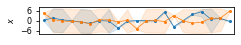

In [14]:
plt.figure(figsize=(3.5,0.5))

for k in range(2):
    plt.fill_between(
        torch.arange(f1, f2),
        model.params["d/x"]["LL"][k, n, f1:f2], model.params["d/x"]["UL"][k, n, f1:f2],
        alpha=0.15, color=f"C{k}"
    )
    plt.plot(
        torch.arange(f1, f2),
        model.params["d/x"]["Mean"][k, n, f1:f2],
        "o-", ms=2, lw=0.7, color=f"C{k}",
    )

plt.xticks([])
plt.yticks([-6, 0, 6], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylabel(r"$x$", fontsize=8)

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/lamda-x.svg")
plt.show()

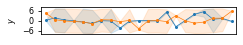

In [15]:
plt.figure(figsize=(3.5,0.5))

for k in range(2):
    plt.fill_between(
        torch.arange(f1, f2),
        model.params["d/x"]["LL"][k, n, f1:f2], model.params["d/x"]["UL"][k, n, f1:f2],
        alpha=0.15, color=f"C{k}"
    )
    plt.plot(
        torch.arange(f1, f2),
        model.params["d/x"]["Mean"][k, n, f1:f2],
        "o-", ms=2, lw=0.7, color=f"C{k}",
    )

plt.xticks([])
plt.yticks([-6, 0, 6], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylabel(r"$y$", fontsize=8)

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/lamda-y.svg")
plt.show()

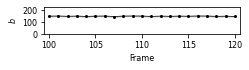

In [17]:
plt.figure(figsize=(3.5,0.5))

plt.fill_between(
    torch.arange(f1, f2),
    model.params["d/background"]["LL"][n, f1:f2], model.params["d/background"]["UL"][n, f1:f2],
    alpha=0.15, color="k"
)
plt.plot(
    torch.arange(f1, f2),
    model.params["d/background"]["Mean"][n, f1:f2],
    "o-", ms=2, lw=0.7, color="k"
)

plt.xticks(torch.arange(f1, f2+5, 5), fontsize=8)
plt.yticks([0, 100, 200], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(0, 230)
plt.ylabel(r"$b$", fontsize=8)
#plt.legend(fontsize=8)
plt.xlabel("Frame", fontsize=8)

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/lamda-b.svg")
plt.show()

## Figure 5

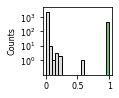

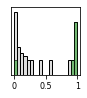

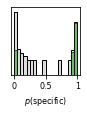

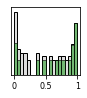

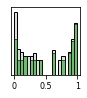

In [19]:
for name in truth_df.index:
    plt.figure(figsize=(1.25, 1.25))
    plt.hist(predictions[name]["z_all"].numpy(),
             bins=torch.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="#dddddd", edgecolor="k",
             label=f"{truth_df.loc[name, 'SNR']:.2f} SNR")
    plt.hist(predictions[name]["z_masked"].numpy(),
             bins=torch.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="C2", edgecolor="k", alpha=0.6,
             label=f"{truth_df.loc[name, 'SNR']:.2f} SNR")
    plt.yscale("log")
    plt.xlim(-0.05,1.05)
    plt.ylim(1e-1, 5e3)
    plt.xticks([0, 0.5, 1], fontsize=8)
    
    if name == "lamda0.01":
        plt.ylabel("Counts", fontsize=8)
        plt.yticks([1, 10, 100, 1000], fontsize=8)
    else:
        plt.yticks([])
    if name == "lamda0.15":
        plt.xlabel(r"$p(\mathsf{specific})$", fontsize=8)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
    # plt.savefig(f"/home/ordabayev/repos/tapqir-overleaf/figures/figure5/{name}.svg")
    plt.show()

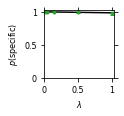

In [21]:
fig, ax = plt.subplots(figsize=(1.25, 1.25))
ax.errorbar(truth_df["lamda"], [fit[i].loc["p(specific)", "Mean"] for i in truth_df.index],
             yerr=torch.tensor([abs(fit[i].loc["p(specific)", ["95% LL", "95% UL"]].values - fit[i].loc["p(specific)", "Mean"]) for i in truth_df.index]).T,
             fmt="o-", ms=3, color="k", mfc="C2", mec="C2", ecolor="C2", capsize=2)
ax.set_xlim(0, 1.03)
ax.set_ylim(0, 1.03)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
ax.tick_params(axis="x", labelsize=8, top=True)
ax.tick_params(axis="y", labelsize=8, right=True)
ax.set_xlabel(r"$\lambda$", fontsize=8)
ax.set_ylabel(r"$p(\mathsf{specific})$", fontsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure5/lamda-pspecific.svg")
plt.show()

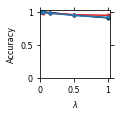

In [22]:
fig, ax = plt.subplots(figsize=(1.25, 1.25))
ax.plot(
    truth_df["lamda"],
    [fit[i].loc["Recall", "Mean"] for i in truth_df.index],
    "o-", color="k", ms=3, label="Recall"
)
ax.plot(
    truth_df["lamda"],
    [fit[i].loc["Precision", "Mean"] for i in truth_df.index],
    "o-", color="C3", ms=3, label="Recall"
)
ax.plot(
    truth_df["lamda"],
    [fit[i].loc["MCC", "Mean"] for i in truth_df.index],
    "o-", color="C0", ms=3, label="Recall"
)
ax.set_xlim(0, 1.03)
ax.set_ylim(0, 1.03)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
ax.tick_params(axis="x", labelsize=8, top=True)
ax.tick_params(axis="y", labelsize=8, right=True)
ax.set_xlabel(r"$\lambda$", fontsize=8)
ax.set_ylabel("Accuracy", fontsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure5/lamda-accuracy.svg")
plt.show()